## Setup

In [1]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py

import setup_google_colab
setup_google_colab.setup_week4()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2018-10-20 13:16:06--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3595 (3.5K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.51K  --.-KB/s    in 0s      

2018-10-20 13:16:06 (65.8 MB/s) - ‘setup_google_colab.py’ saved [3595/3595]

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
import keras, keras.layers as L, keras.backend as K
import tensorflow as tf

# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

Using TensorFlow backend.


In [0]:
# token expires every 30 min
COURSERA_TOKEN = 'xwUykND0orYrYEg4'
COURSERA_EMAIL = 'dangledangkhoa@gmail.com'

## Load dataset 
Dataset was downloaded for you. Relevant links (just in case):
- http://vis-www.cs.umass.edu/lfw/
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [0]:
# we downloaded them for you, just link them here
! ln -s $(realpath ../readonly/week4/*) .

In [7]:
from lfw_dataset import load_lfw_dataset

# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

IMG_SHAPE = X.shape[1:]

**************************************************



In [0]:
# center images
X = X.astype('float32') / 255.0 - 0.5

In [0]:
from sklearn.model_selection import train_test_split

# split dataset
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Sample Images

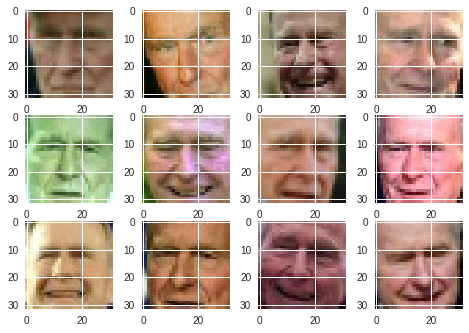

In [10]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
    

plt.title('sample images')

for i in range(12):
    plt.subplot(3,4,i+1)
    show_image(X[i])

In [11]:
print("X shape:", X.shape)
print("attr shape:", attr.shape)

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


In [12]:
# try to free memory
del X
import gc
gc.collect()

22462

# Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="images/autoencoder.png" style="width:50%">
<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## PCA Autoencoder

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)
<img src="images/pca.png" style="width:30%">


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [0]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

In [14]:
# Meld them together into one model
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

# model
autoencoder = keras.models.Model(
    inputs=inp,
    outputs=reconstruction)

# Compile
autoencoder.compile(optimizer='adamax', loss='mse')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
import keras_utils

# Train PCA
history = autoencoder.fit(
    x=X_train, y=X_train,
    epochs=15,
    validation_data=[X_test, X_test],
    callbacks=[keras_utils.TqdmProgressCallback()],
    verbose=False)


Epoch 1/15
**************************************************
loss: 0.0124; val_loss: 0.0085

Epoch 2/15
**************************************************
loss: 0.0076; val_loss: 0.0070

Epoch 3/15
**************************************************
loss: 0.0068; val_loss: 0.0067

Epoch 4/15
**************************************************
loss: 0.0067; val_loss: 0.0067

Epoch 5/15
**************************************************
loss: 0.0067; val_loss: 0.0067

Epoch 6/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 7/15
**************************************************
loss: 0.0067; val_loss: 0.0067

Epoch 8/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 9/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 10/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 11/15
**********************************************

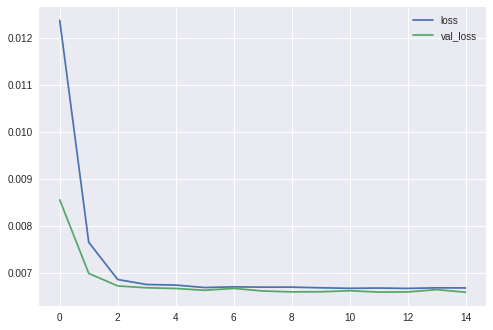

In [16]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

In [17]:
# Evaluation
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

PCA MSE: 0.006580282202408341


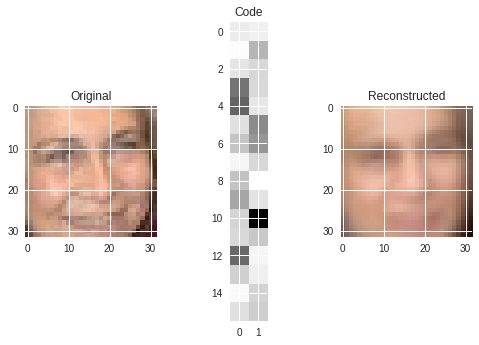

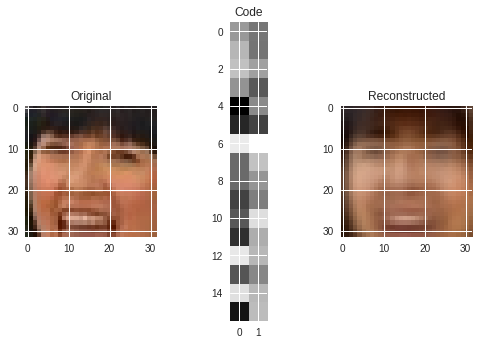

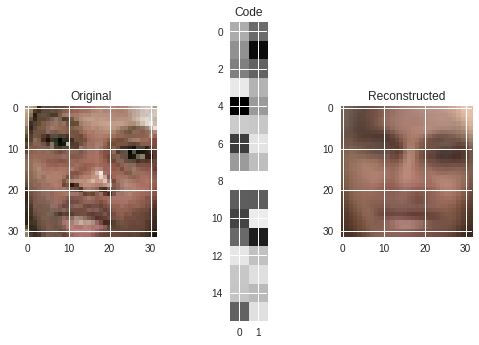

In [18]:
# Visualize
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()
    
    
for i in range(3):
    img = X_test[i]
    visualize(img,encoder,decoder)

##  Deep Autoencoder - Convolutional autoencoder

PCA is neat but surely we can do better. This time we want you to build a deep convolutional autoencoder by... stacking more layers.

### Encoder

The **encoder** part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (`code_size`).

We recommend to use `activation='elu'` for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`.

Remember to flatten (`L.Flatten()`) output before adding the last dense layer!

### Decoder

For **decoder** we will use so-called "transpose convolution". 

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3 (watch [this video](https://www.coursera.org/learn/intro-to-deep-learning/lecture/auRqf/a-glimpse-of-other-computer-vision-tasks) starting at 5:41).

Here's how "transpose convolution" works:
<img src="images/transpose_conv.jpg" style="width:60%">
In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
```python
L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
```

Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" `L.Flatten()` in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 `L.Conv2DTranspose` layers with the following numbers of output channels: `128, 64, 32, 3`. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last `L.Conv2DTranspose` layer use `activation=None` because that is our final image.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

In [0]:
from keras.layers import Conv2D, Deconv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D

def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(Conv2D(filters=code_size*8, kernel_size=2, padding='same', activation='relu'))
    encoder.add(Conv2D(filters=code_size*4, kernel_size=2, padding='same', activation='relu'))
    encoder.add(Conv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    encoder.add(Conv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    encoder.add(MaxPooling2D())
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    
    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size, )))
    
    decoder.add(L.Dense(int(H/2*W/2*code_size)))
    decoder.add(L.Reshape( (int(H/2), int(W/2), int(code_size))) )
    decoder.add(Deconv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    decoder.add(Deconv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    decoder.add(Deconv2D(filters=code_size*4, kernel_size=2, padding='same', activation='relu'))
    decoder.add(Deconv2D(filters=code_size*8, kernel_size=2, padding='same', activation='relu'))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(filters=C, kernel_size=3, padding='same', activation='tanh'))


    return encoder,decoder

In [20]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = reset_tf_session()
    
    # Model
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    
    # Test
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = reset_tf_session()

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [21]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

display(encoder.summary())
display(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       3328      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              270336    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        4128      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 32)        4128      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 128)       16512     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 256)       131328    
__________

None

In [0]:
s = reset_tf_session()

# model
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

# In/Code/Out
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

# Meld
autoencoder = keras.models.Model(
    inputs=inp, outputs=reconstruction)

# Compile
autoencoder.compile(optimizer="adamax", loss='mse')

In [23]:
# Checkpoint
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(
    filepath='weights.best.deepEncoder.hdf5', 
    verbose=1, save_best_only=True)

# Early Stopping
from keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(monitor='loss', patience=1)

# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0}.hdf5'

#### uncomment below to continue training from model checkpoint
#### every time epoch counter starts at 0, so you need to track epochs manually
# from keras.models import load_model
# s = reset_tf_session()
# autoencoder = load_model(model_filename.format(0))  # continue after epoch 0+1
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

# Train Deep Autoencoder
history = autoencoder.fit(
    x=X_train, y=X_train,
    epochs=25,
    validation_data=[X_test, X_test],
    callbacks=[
        keras_utils.TqdmProgressCallback(),
        checkpointer,
        earlystopper],
    verbose=0)


Epoch 1/25
**************************************************
loss: 0.0126; val_loss: 0.0074
Epoch 00000: val_loss improved from inf to 0.00742, saving model to weights.best.deepEncoder.hdf5

Epoch 2/25
**************************************************
loss: 0.0070; val_loss: 0.0067
Epoch 00001: val_loss improved from 0.00742 to 0.00666, saving model to weights.best.deepEncoder.hdf5

Epoch 3/25
**************************************************
loss: 0.0065; val_loss: 0.0064
Epoch 00002: val_loss improved from 0.00666 to 0.00636, saving model to weights.best.deepEncoder.hdf5

Epoch 4/25
**************************************************
loss: 0.0062; val_loss: 0.0062
Epoch 00003: val_loss improved from 0.00636 to 0.00617, saving model to weights.best.deepEncoder.hdf5

Epoch 5/25
**************************************************
loss: 0.0061; val_loss: 0.0062
Epoch 00004: val_loss did not improve

Epoch 6/25
**************************************************
loss: 0.0059; val_loss: 0

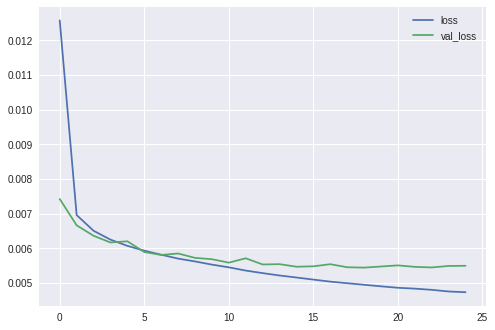

In [24]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

In [0]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [26]:
# Evaluation
autoencoder.load_weights('weights.best.deepEncoder.hdf5')

reconstruction_mse = autoencoder.evaluate(
    X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

Convolutional autoencoder MSE: 0.005440234632971395


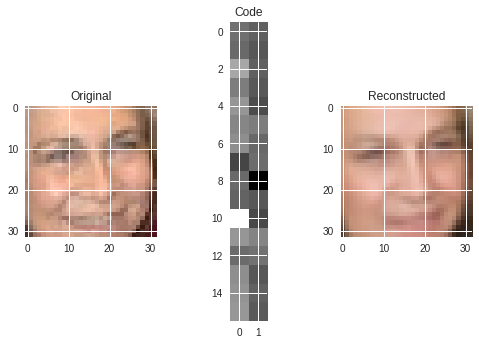

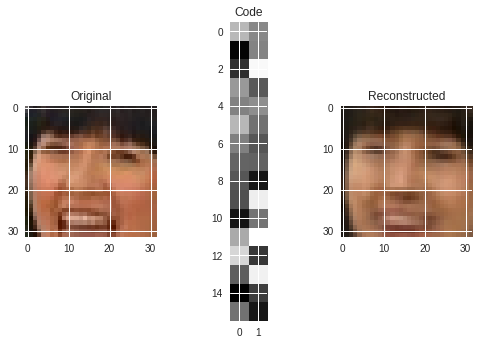

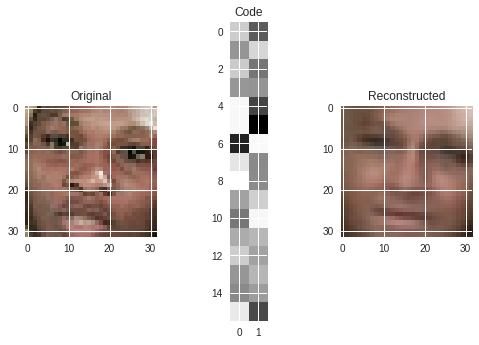

In [27]:
# Visualize
for i in range(3):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [28]:
# Evaluate Auto encoder, decoder
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.00549303459998631
0.005440234632971395


In [29]:
# Submit to Coursera
from submit import submit_autoencoder
submission = build_deep_autoencoder(IMG_SHAPE, code_size=71)

submit_autoencoder(
    submission, reconstruction_mse, 
    COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.This part is **optional**, it shows you one useful application of autoencoders: denoising. You can run this code and make sure denoising works :) 

Let's now turn our model into a denoising autoencoder:
<img src="images/denoising.jpg" style="width:40%">

We'll keep the model architecture, but change the way it is trained. In particular, we'll corrupt its input data randomly with noise before each epoch.

There are many strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. We will add gaussian white noise.

In [0]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """

    ### YOUR CODE HERE ###
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

In [0]:
# noise tests
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()

assert abs(theoretical_std - our_std) < 0.01, \
  "Standard deviation does not match it's required value. Make sure you use sigma as std."
  
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01, \
  "Mean has changed. Please add zero-mean noise"

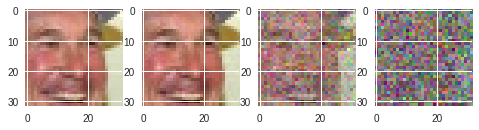

In [32]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

# test different noise scales
plt.subplot(1,4,1)
plt.imshow(normalize(X_train[0]))

plt.subplot(1,4,2)
plt.imshow(normalize(apply_gaussian_noise(X_train[:1],sigma=0.01)[0]))

plt.subplot(1,4,3)
plt.imshow(normalize(apply_gaussian_noise(X_train[:1],sigma=0.1)[0]))

plt.subplot(1,4,4)
plt.imshow(normalize(apply_gaussian_noise(X_train[:1],sigma=0.5)[0]))

In [0]:
s = reset_tf_session()

# we use bigger code size here for better quality
encoder,decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

In [0]:
import keras_utils

# Training will take several hours.
for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(
        x=X_train_noise, y=X_train,
        epochs=1,
        validation_data=[X_test_noise, X_test],
        callbacks=[keras_utils.TqdmProgressCallback()],
        verbose=1)

Epoch 1/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples

Epoch 1/1
Epoch 1/1
11808/11828 [============================>.] - ETA: 3s - loss: 0.1041
loss: 0.1039; val_loss: 0.0293
11828/11828 [==============================] - 2286s - loss: 0.1040 - val_loss: 0.0293
Epoch 2/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples

Epoch 1/1
Epoch 1/1
11808/11828 [============================>.] - ETA: 3s - loss: 0.0297
loss: 0.0297; val_loss: 0.0295
11828/11828 [==============================] - 2251s - loss: 0.0297 - val_loss: 0.0295
Epoch 3/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples

Epoch 1/1
Epoch 1/1
11808/11828 [============================>.] - ETA: 3s - loss: 0.0297
loss: 0.0297; val_loss: 0.0298
11828/11828 [==============================] - 2249s - loss: 0.0297 - val_loss: 0.0298
Epoch 4/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples



In [0]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

In [0]:
# Evaluate
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

## Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see them in action.

First thing we can do is image retrieval aka image search. We will give it an image and find similar images in latent space:

<img src="images/similar_images.jpg" style="width:60%">

To speed up retrieval process, one should use Locality Sensitive Hashing on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of our image in latent space (encoder code). We will caclulate nearest neighbours in brute force way for simplicity.

In [0]:
# restore trained encoder weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [0]:
images = X_train
codes = encoder() ### YOUR CODE HERE: encode all images ###

assert len(codes) == len(images)

In [0]:
from sklearn.neighbors.unsupervised import NearestNeighbors

nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

In [0]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [0]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

In [0]:
#smiles
show_similar(X_test[2])

In [0]:
#ethnicity
show_similar(X_test[500])

In [0]:
#glasses
show_similar(X_test[66])

## Cheap image morphing

In [0]:
# restore trained encoder weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

In [0]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()